# Intro

PCA analysis on the meta-session to see value (history) representation.

---
# Setup

In [1]:
#%% imports
import os

from sklearn.decomposition import PCA
import pandas as pdr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr

import popy.config as cfg
import popy.config as cfg

#from popy.dim_reduction import *
from popy.plotting.plotting_tools import plot_keypoints
from popy.plotting.plot_cortical_grid import plot_on_cortical_grid


PATH = cfg.PROJECT_PATH_LOCAL

In [2]:
#%% data tools
def load_data_custom():
    # load data (meta session)
    floc = os.path.join(PATH, 'data', 'processed', 'neural_data', 'meta_rates_value')
    neural_dataset =  xr.open_dataset(floc + '/meta_rates.nc')

    # add coordinates (should be added during the dataset creation)
    '''neural_dataset = neural_dataset.assign_coords(R_1=('trial_id', [0 if hist in [0, 1, 2, 3] else 1 for hist in neural_dataset.history_of_feedback.values]))
    neural_dataset = neural_dataset.assign_coords(R_2=('trial_id', [0 if hist in [0, 1, 4, 5] else 1 for hist in neural_dataset.history_of_feedback.values]))
    neural_dataset = neural_dataset.assign_coords(R_3=('trial_id', [0 if hist in [0, 2, 4, 6] else 1 for hist in neural_dataset.history_of_feedback.values]))
    neural_dataset = neural_dataset.assign_coords(fb_sequence=('trial_id', neural_dataset.history_of_feedback.values))
    neural_dataset = neural_dataset.assign_coords(fb_sequence_m1=('trial_id', neural_dataset.history_of_feedback.values%4))
    '''
    neural_dataset = neural_dataset.assign_coords(time_m1=('time', neural_dataset.time.values + 7.5))

    # normalize firing rates (z-score) and remove units with low firing rates
    threshold = 1  # Hz
    units_to_remove = []
    normalized_data = np.zeros_like(neural_dataset.firing_rates.data)  # Create a copy to avoid modifying the original data
    for i, unit in enumerate(neural_dataset.unit.values):  # Loop through each neuron
        # Get all data for this neuron across trials and timepoints
        unit_data = neural_dataset.firing_rates.sel(unit=unit).values
        
        # Calculate mean and std across all values for this neuron
        mean_val = np.mean(unit_data)
        std_val = np.std(unit_data)
        
        # Z-score normalize and store in the output array
        if mean_val < threshold:
            units_to_remove.append(unit)
        elif std_val == 0:
            raise ValueError(f"Standard deviation is zero for unit {unit}. Not possible.")
        else:
            z_scored_data = (unit_data - mean_val) / std_val        
            normalized_data[:, i, :] = z_scored_data

    #neural_dataset.firing_rates.values = normalized_data
    neural_dataset['firing_rates'] = (neural_dataset.firing_rates.dims, normalized_data)

    neural_dataset = neural_dataset.sel(unit=~neural_dataset.unit.isin(units_to_remove))
    print(f"Removed {len(units_to_remove)} units with mean firing rate < {threshold} Hz")

    return neural_dataset

def fit_transform_data(neural_dataset):
    n_trials, n_neurons, n_time = neural_dataset.firing_rates.data.shape
        
    # Step 1: Reshape to (neurons, trials*time)
    reshaped_data = neural_dataset.firing_rates.data.transpose(1, 0, 2).reshape(n_neurons, -1)

    # smooth the data
    '''unit_smooth = [np.convolve(unit, np.ones(50)/50, mode='same') for unit in reshaped_data]
    reshaped_data = np.array(unit_smooth)

    corr_matrix = np.corrcoef(reshaped_data)
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0, vmin=-.1, vmax=.1)
    plt.title('Correlation Matrix of Smoothed Firing Rates')
    plt.xlabel('Units')
    plt.ylabel('Units')
    plt.show()'''

    # Step 2: Apply PCA (scikit-learn expects samples as rows, features as columns)
    pca = PCA()
    pca = pca.fit(reshaped_data.T)  # Shape: (trials*time, components)
    transformed_data = pca.transform(reshaped_data.T)  # Apply PCA transformation

    # Step 3: Reshape back to (trials, components, time)
    transformed_data = transformed_data.T  # Shape: (components, trials*time)
    transformed_data = transformed_data.reshape(n_neurons, n_trials, n_time)
    transformed_data = transformed_data.transpose(1, 0, 2)  # Final shape: (trials, components, time)

    # rewrite the dataset
    pca_dataset = neural_dataset.copy(deep=True)
    pca_dataset = pca_dataset.rename({'unit': 'pca_component'})
    pca_dataset = pca_dataset.drop('channel')
    pca_dataset = pca_dataset.drop('area')
    pca_dataset = pca_dataset.drop('unit_id_original')
    pca_dataset = pca_dataset.drop('monkey')
    pca_dataset = pca_dataset.drop('session')
    # add pca_component dimension
    pca_dataset = pca_dataset.assign_coords(pca_component=('pca_component', np.arange(n_neurons)))
    pca_dataset = pca_dataset.assign_coords(explained_var=('pca_component', pca.explained_variance_ratio_))
    pca_dataset.firing_rates.data = transformed_data

    # create xr dataset for the pca components (components, units)
    pca_components = xr.DataArray(pca.components_, dims=['pca_component', 'unit'], coords=[np.arange(n_neurons), neural_dataset.unit.values])

    return pca_dataset, pca_components


def get_weights_per_area(pca_components, pca_component):
    '''
    Get the weights of the PCA components per area
    '''
    weights_temp = pca_components.sel(pca_component=pca_component)

    # to df, where columns are monkey, session, area, unit, weight
    data_to_df = []
    for unit_temp in weights_temp.unit.values:
        data_to_df.append(
            {'monkey': unit_temp.split('_')[0],
            'session': unit_temp.split('_')[1],
            'area': unit_temp.split('_')[2],
            'unit': "_".join(unit_temp.split('_')[3:]),
            'weight': weights_temp.sel(unit=unit_temp).values
            }
        )
    df = pdr.DataFrame(data_to_df)
    df['weight_ratio'] =np.abs(df['weight'])/np.sum(np.abs(df['weight']))

    # get best weight per monkey, session, area (drop unit)
    df_abs = df.copy()
    df_abs['weight'] = df_abs['weight'].abs()

    df_best = df_abs.groupby(['monkey', 'session', 'area']).agg({'weight': 'max'}).reset_index()
    df_best = df_best.rename(columns={'weight': 'best_weight'})
    df_best['best_weight_ratio'] = df_best['best_weight'] / df_abs['weight'].sum()

    df_sum = df_abs.groupby(['monkey', 'session', 'area']).agg({'weight': 'sum'}).reset_index()
    df_sum = df_sum.rename(columns={'weight': 'sum_weight'})
    df_sum['sum_weight_ratio'] = df_sum['sum_weight'] / df_abs['weight'].sum()
    df_best = df_best.merge(df_sum, on=['monkey', 'session', 'area'], how='left')

    df_mean = df_abs.groupby(['monkey', 'session', 'area']).agg({'weight': 'mean'}).reset_index()
    df_mean = df_mean.rename(columns={'weight': 'mean_weight'})
    df_best = df_best.merge(df_mean, on=['monkey', 'session', 'area'], how='left')

    return df_best



In [3]:
##% plotting functions

def plot_pca_components_history(pca_dataset, pca_components, monkey, area_title, n_components=10, t_min=None, t_max=None, mean_subtract=False):
    # define what to show
    value_labels = pca_dataset.fb_sequence_m1.values
    outcome_labels = pca_dataset.R_1.values

    # shift time! it is necessary if the value now belongs to the previous trial

    fig, axs = plt.subplots(n_components, 2, figsize=(16, 4*n_components), sharex=False)
    fig.suptitle(f'{monkey}, {area_title}', y=1)

    colors = sns.color_palette("RdYlGn", len(np.unique(value_labels)))  # colors for each value
    linestyles = {0:'--', 1:'-'}  # linestyles for each feedback

    for i in range(n_components):
        # prepare data for this PC
        unit_data = pca_dataset.firing_rates.sel(pca_component=i)  # select PC
        unit_data.data = np.array([np.convolve(trial, np.ones(50)/50, mode='same') for trial in unit_data.data])  # smooth the data

        if t_min is not None and t_max is not None:  # select time window
            unit_data = unit_data.sel(time=slice(t_min, t_max))  

        if mean_subtract:  # substract mean along time
            unit_data.data = unit_data.data - np.mean(unit_data.data, axis=0, keepdims=True)  

        # plot single PC activity
        ax = axs[i, 0]
        plot_single_unit(unit_data, value_labels, labels_2=outcome_labels,
                        title=f'PCA component {i}, variance explained: {pca_dataset.explained_var[i]*100:.1f}%',
                        n_extra_trials=(0, 1),
                        ax=ax, colors=colors, linestyles=linestyles)
        ax.set_ylabel('activity')  # rewrite y label from firing rate to activity"""

        # plot weights on the surface
        """
        What should be the measure? The proble is the weights are correspondig to units, and we want to plot weights over areas, thus we need to average the weights over units somehow.
        Solution 1: average the weights over units per area
        Solution 2: Plot best unit per area
        Solution 3: plot proportion of weights per area relative to all units (e.g. 0.5 means that 50% of the weights are in this area)
        """
        ax = axs[i, 1]
        
        df_weights = get_weights_per_area(pca_components, i)
        df_weights['sum_weight_ratio'] = df_weights['sum_weight_ratio'] * 100  # convert to percentage

        plot_on_cortical_grid(df_weights, 'sum_weight_ratio', 
                            ax=ax, 
                            title=f'PCA component {i}, variance explained: {pca_dataset.explained_var[i]*100:.1f}%',
                            bar_title='percentage of weights given by area (%)',) 

    plt.tight_layout()


def plot_pca_components_value(pca_dataset, pca_components, monkey, area_title, n_components=10, t_min=None, t_max=None, mean_subtract=False):
    # define what to show
    value_labels = pca_dataset.value_function.values
    outcome_labels = pca_dataset.feedback.values

    # shift time! it is necessary if the value now belongs to the previous trial

    fig, axs = plt.subplots(n_components, 2, figsize=(16, 4*n_components), sharex=False)
    fig.suptitle(f'{monkey}, {area_title}', y=1)

    colors = sns.color_palette("RdYlGn", len(np.unique(value_labels)))  # colors for each value
    linestyles = {0:'--', 1:'-'}  # linestyles for each feedback

    for i in range(n_components):
        # prepare data for this PC
        unit_data = pca_dataset.firing_rates.sel(pca_component=i)  # select PC
        unit_data.data = np.array([np.convolve(trial, np.ones(50)/50, mode='same') for trial in unit_data.data])  # smooth the data

        if t_min is not None and t_max is not None:  # select time window
            unit_data = unit_data.sel(time=slice(t_min, t_max))  

        if mean_subtract:  # substract mean along time
            unit_data.data = unit_data.data - np.mean(unit_data.data, axis=0, keepdims=True)  

        # plot single PC activity
        ax = axs[i, 0]
        plot_single_unit(unit_data, value_labels, labels_2=outcome_labels,
                        title=f'PCA component {i}, variance explained: {pca_dataset.explained_var[i]*100:.1f}%',
                        n_extra_trials=(0, 1),
                        ax=ax, colors=colors, linestyles=linestyles)
        ax.set_ylabel('activity')  # rewrite y label from firing rate to activity"""

        # plot weights on the surface
        """
        What should be the measure? The proble is the weights are correspondig to units, and we want to plot weights over areas, thus we need to average the weights over units somehow.
        Solution 1: average the weights over units per area
        Solution 2: Plot best unit per area
        Solution 3: plot proportion of weights per area relative to all units (e.g. 0.5 means that 50% of the weights are in this area)
        """
        ax = axs[i, 1]
        
        df_weights = get_weights_per_area(pca_components, i)
        df_weights['sum_weight_ratio'] = df_weights['sum_weight_ratio'] * 100  # convert to percentage

        plot_on_cortical_grid(df_weights, 'sum_weight_ratio', 
                            ax=ax, 
                            title=f'PCA component {i}, variance explained: {pca_dataset.explained_var[i]*100:.1f}%',
                            bar_title='percentage of weights given by area (%)',) 

    plt.tight_layout()



def plot_correlation_matrix(neural_dataset, monkey, area_title):
    reshaped_data = neural_dataset.firing_rates.data.transpose(1, 0, 2).reshape(len(neural_dataset.unit), -1)
    corr_matrix = np.corrcoef(reshaped_data)
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0, vmin=-.1, vmax=.1)
    plt.title(f'Correlation Matrix of all Firing Rates\n{monkey} {area_title}')
    plt.xlabel('Units')
    plt.ylabel('Units')
    plt.show()

    
def plot_single_unit(unit_data, labels, labels_2=None, colors=None, linestyles=None, n_extra_trials=(-1, 0), title=None, ax=None):
    time_vector = unit_data.time.data

    # plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    # get mean counts by conditions
    for i, label in enumerate(np.unique(labels)):
        if labels_2 is not None:
            for j, label_2 in enumerate(np.unique(labels_2)):
                    trial_ids = unit_data.trial_id[(labels == label) & (labels_2 == label_2)]
                    mean_count = np.mean(unit_data.sel(trial_id=trial_ids), axis=0)
                    ax.plot(time_vector, mean_count, label=f'V_t={label}, R_t={label_2}', color=colors[i], linestyle=linestyles[j])
        else:
            trial_ids = unit_data.trial_id[labels == label]
            mean_count = np.mean(unit_data.sel(trial_id=trial_ids), axis=0)
            ax.plot(time_vector, mean_count, label=f'V_t={label}', color=colors[i])
            
    plot_keypoints(ax, n_extra_trials=n_extra_trials, xlabels='events')

    ax.legend(loc='upper right', fontsize=8)

    ax.set_xlabel('time (s)')
    ax.set_ylabel('firing rate (Hz)')
    # grid on x axis only
    ax.grid(alpha=.3, axis='x')

    # Add a box at the top left corner
    x_loc = time_vector[0]
    y_loc = ax.get_ylim()[1] 
    y_loc_text = y_loc - (ax.get_ylim()[1] - ax.get_ylim()[0]) * .18
    y_loc_line = y_loc - (ax.get_ylim()[1] - ax.get_ylim()[0]) * .2
    ax.text(x_loc+.5, y_loc_text, '1s', verticalalignment='bottom', horizontalalignment='center')

    # Plot a unit length horizontal line inside the box
    ax.plot([x_loc, x_loc + 1], [y_loc_line, y_loc_line], color='black')
    ax.scatter([x_loc, x_loc + 1], [y_loc_line, y_loc_line], marker='|', color='black')

    # remove top and right spines
    sns.despine()

    if title is not None:
        ax.set_title(title)

def plot_2pcs(unit_data, labels, pc_a, pc_b, condition=None, title=None, ax=None, colors=None):
    time_vector = unit_data.time.data

    # plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    # get mean counts by condition
    mean_counts = {label: np.mean(unit_data[labels == label], axis=0) for label in np.unique(labels)}

    # plot trial-avg rates by condition
    for i, label in enumerate(np.unique(labels)):        
        ax.scatter(mean_counts[label][pc_a], mean_counts[label][pc_b], label=f'{int(pc_a)}, N={np.sum(labels == pc_a)}', color=colors[0])

    ax.set_xlabel(f'{pc_a}')
    ax.set_ylabel(f'{pc_b}')
    # grid on x axis only
    ax.grid(alpha=.3, axis='x')
    if condition is not None:
        # legend outside of plot
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
    #ax.axhline(0, color='k', alpha=.5) # add zero line

    # remove top and right spines
    sns.despine()

    if title is not None:
        ax.set_title(title)

def plot_2pcs_in_time():
    pass

def plot_explained_variance(pca_dataset, monkey, area):
    '''
    Simply plots the explained variance of the PCA components
    '''
    # plot cummulative explained variance
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.plot(np.cumsum(pca_dataset.explained_var), color='k')
    ax.set_xlabel('PCA component')
    ax.set_ylabel('Cumulative explained variance')
    ax.set_title(f'Cumulative explained variance\n{monkey}, {area}')
    ax.grid(alpha=.3, axis='x')
    sns.despine()
    plt.tight_layout()

    plt.show()


---
# Get data

In [4]:
# Load all units
neural_dataset = load_data_custom()
neural_dataset

Removed 265 units with mean firing rate < 1 Hz


<xarray.Dataset>
Dimensions:           (unit: 2244, time: 1500, trial_id: 160)
Coordinates: (12/13)
    unit_id_original  (unit) int64 ...
    channel           (unit) int64 ...
    monkey            (unit) object ...
    session           (unit) object ...
    area              (unit) object ...
    subregion         (unit) object ...
    ...                ...
    epoch             (time) float64 ...
  * unit              (unit) object 'ka_010720_LPFC_04_01' ... 'po_310822_MCC...
    feedback          (trial_id) int64 ...
    value_function    (trial_id) int64 ...
  * trial_id          (trial_id) int64 0 1 2 3 4 5 6 ... 154 155 156 157 158 159
    time_m1           (time) float64 7.5 7.51 7.52 7.53 ... 22.47 22.48 22.49
Data variables:
    firing_rates      (trial_id, unit, time) float64 -0.2387 0.194 ... 0.8453
Attributes:
    bin_size:  0.01

---
# PCA

In [5]:
# get monkey and area
monkey = 'ka'
neural_dataset_MCC = neural_dataset.sel(unit=(neural_dataset.subregion == 'MCC') & (neural_dataset.monkey==monkey))
neural_dataset_vLPFC = neural_dataset.sel(unit=(neural_dataset.subregion == 'vLPFC') & (neural_dataset.monkey==monkey))
neural_dataset_dLPFC = neural_dataset.sel(unit=(neural_dataset.subregion == 'dLPFC') & (neural_dataset.monkey==monkey))

# Sanity
#plot_correlation_matrix(neural_dataset, monkey, area_title)

# transform to PCA space
pca_dataset_MCC, pca_components_MCC = fit_transform_data(neural_dataset_MCC)
pca_dataset_vLPFC, pca_components_vLPFC = fit_transform_data(neural_dataset_vLPFC)
pca_dataset_dLPFC, pca_components_dLPFC = fit_transform_data(neural_dataset_dLPFC)

# Plot the explained variance
#plot_explained_variance(pca_dataset, monkey, area_title)

## Plot PCs

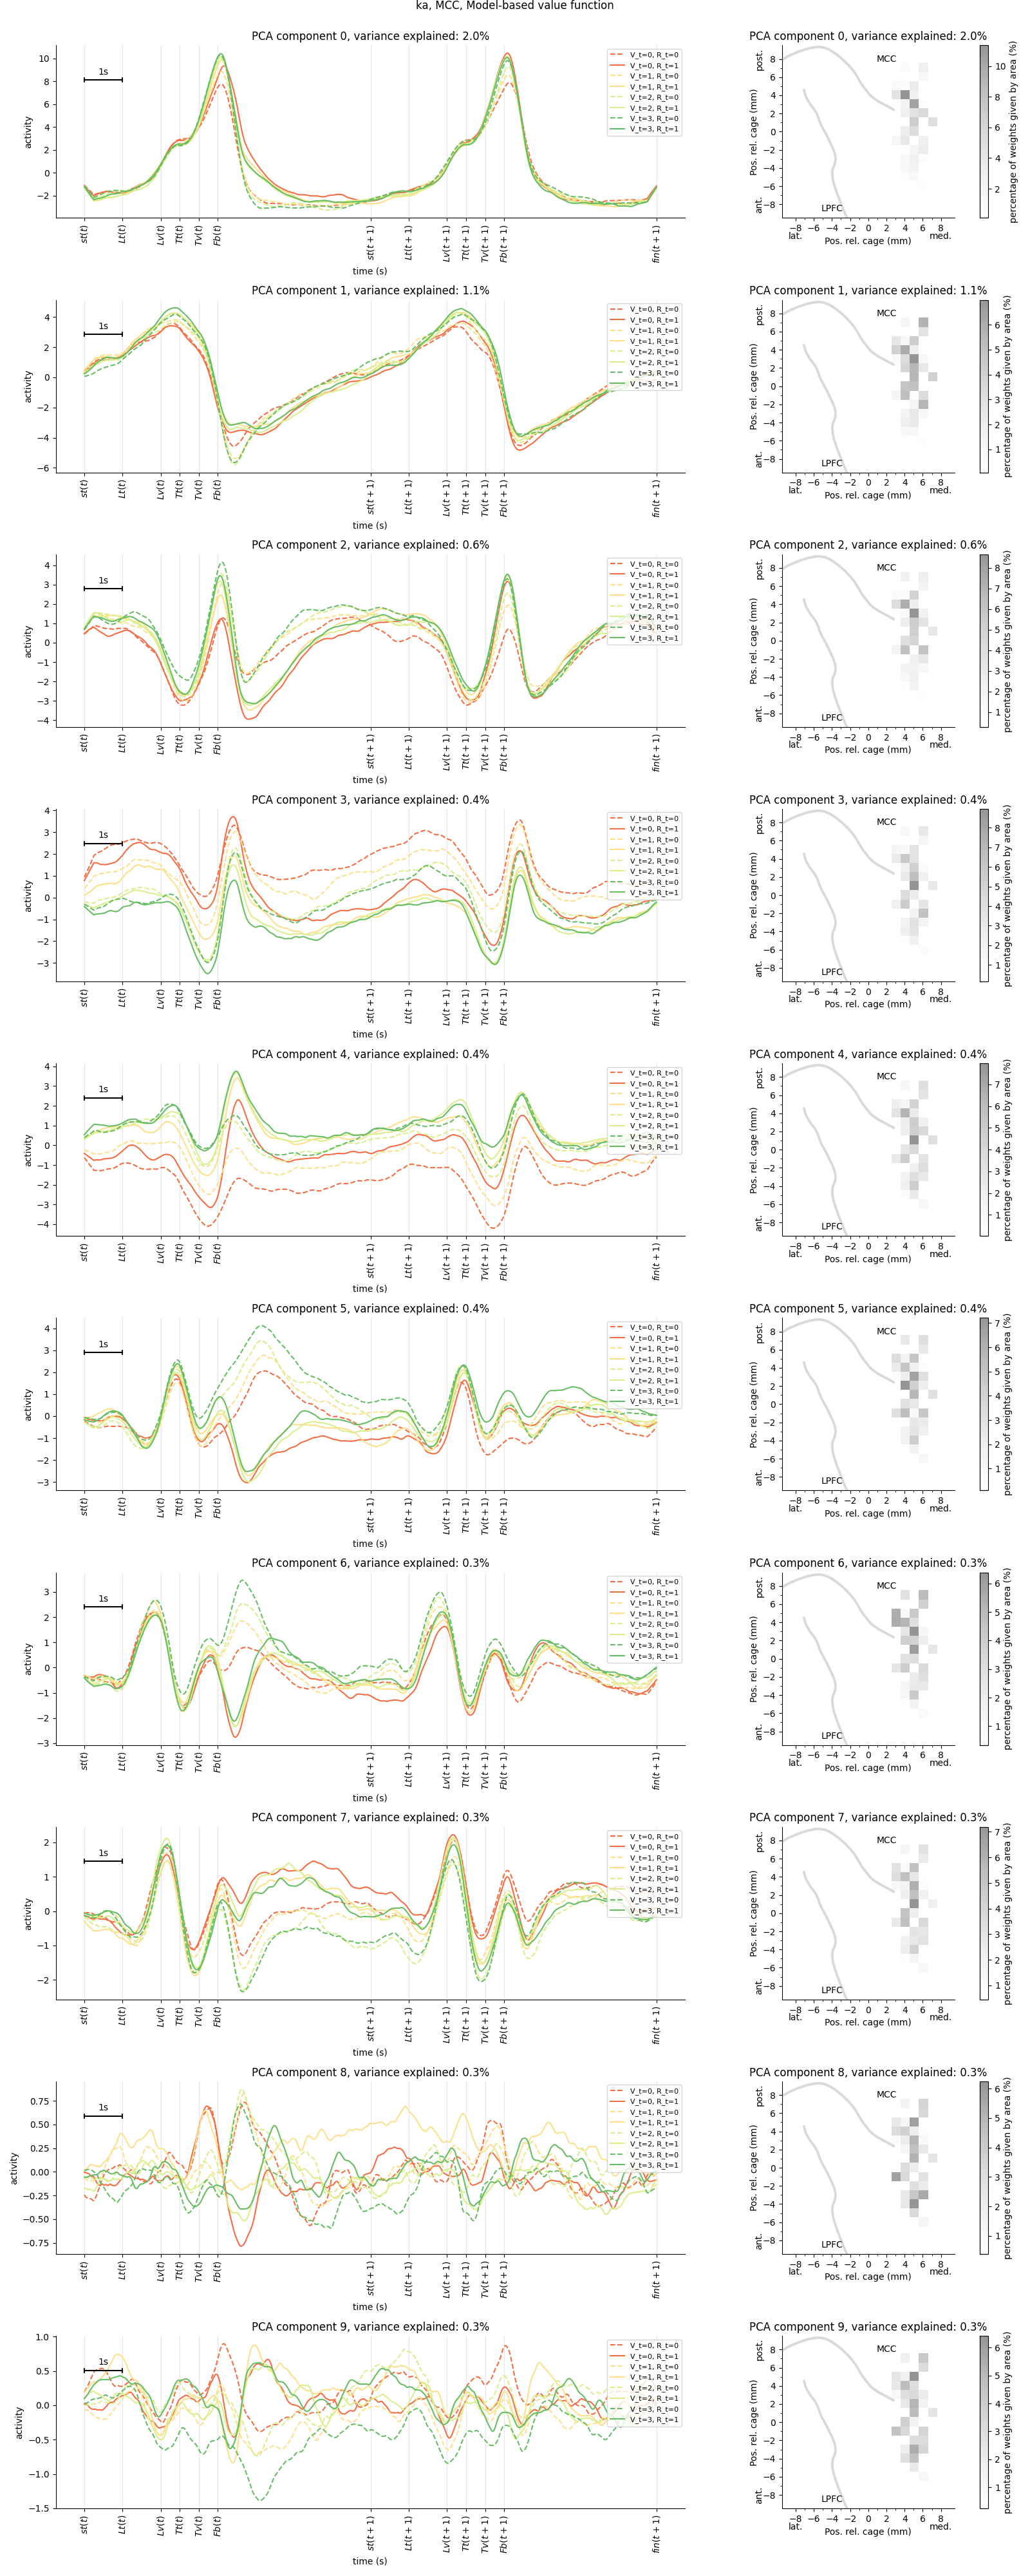

In [106]:
t_min, t_max = None, None#0, 11

pca_dataset = pca_dataset_MCC
pca_components = pca_components_MCC
area_title = 'MCC, Model-based value function'

plot_pca_components_value(pca_dataset, pca_components, monkey, area_title, n_components=10, t_min=t_min, t_max=t_max, mean_subtract=False)

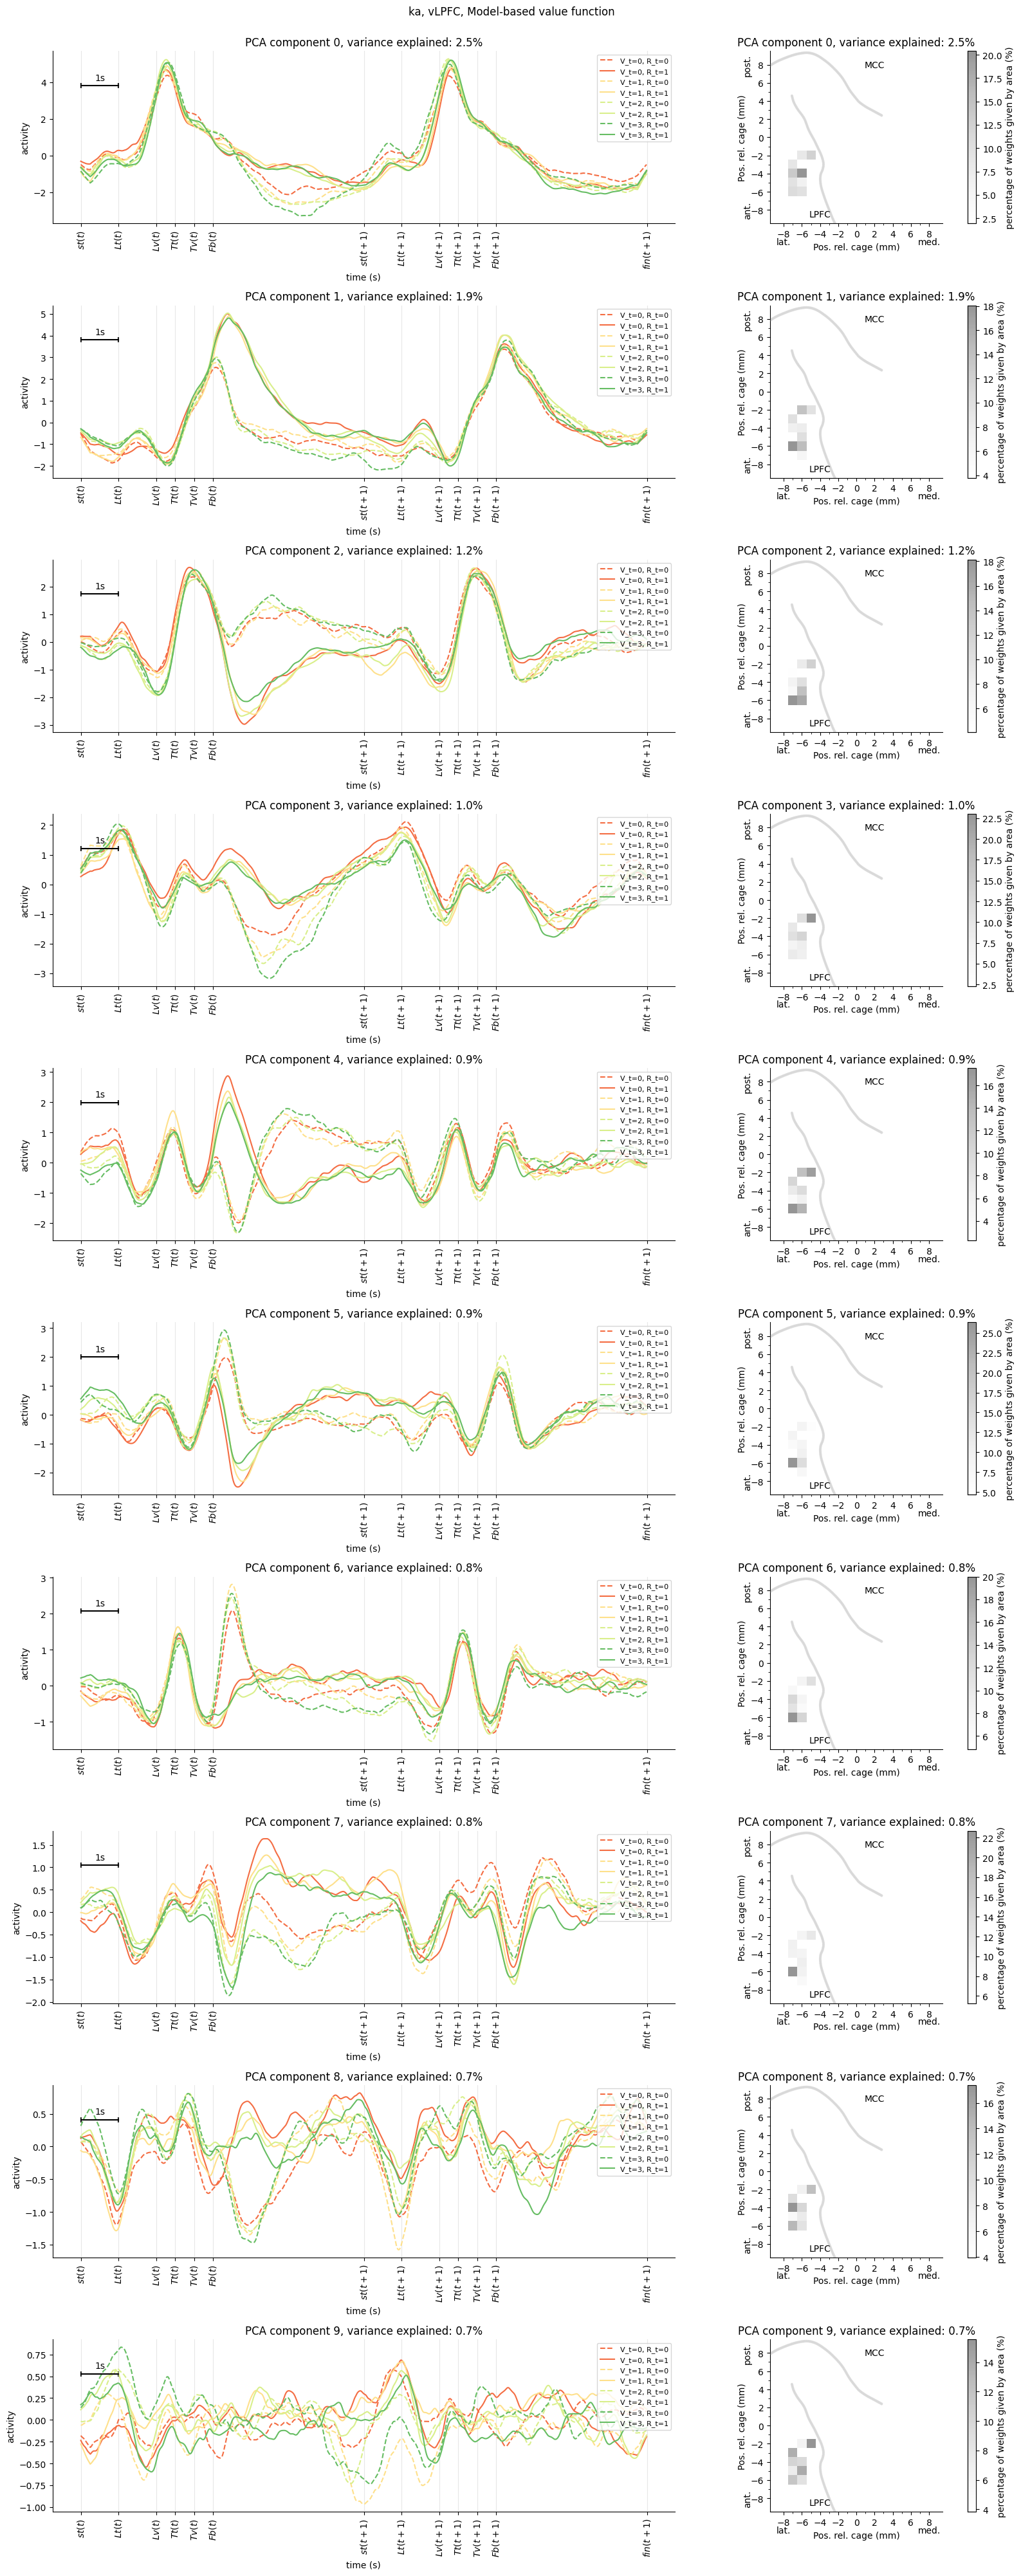

In [7]:
pca_dataset = pca_dataset_vLPFC
pca_components = pca_components_vLPFC
area_title = 'vLPFC, Model-based value function'

plot_pca_components_value(pca_dataset, pca_components, monkey, area_title, n_components=10, t_min=t_min, t_max=t_max)

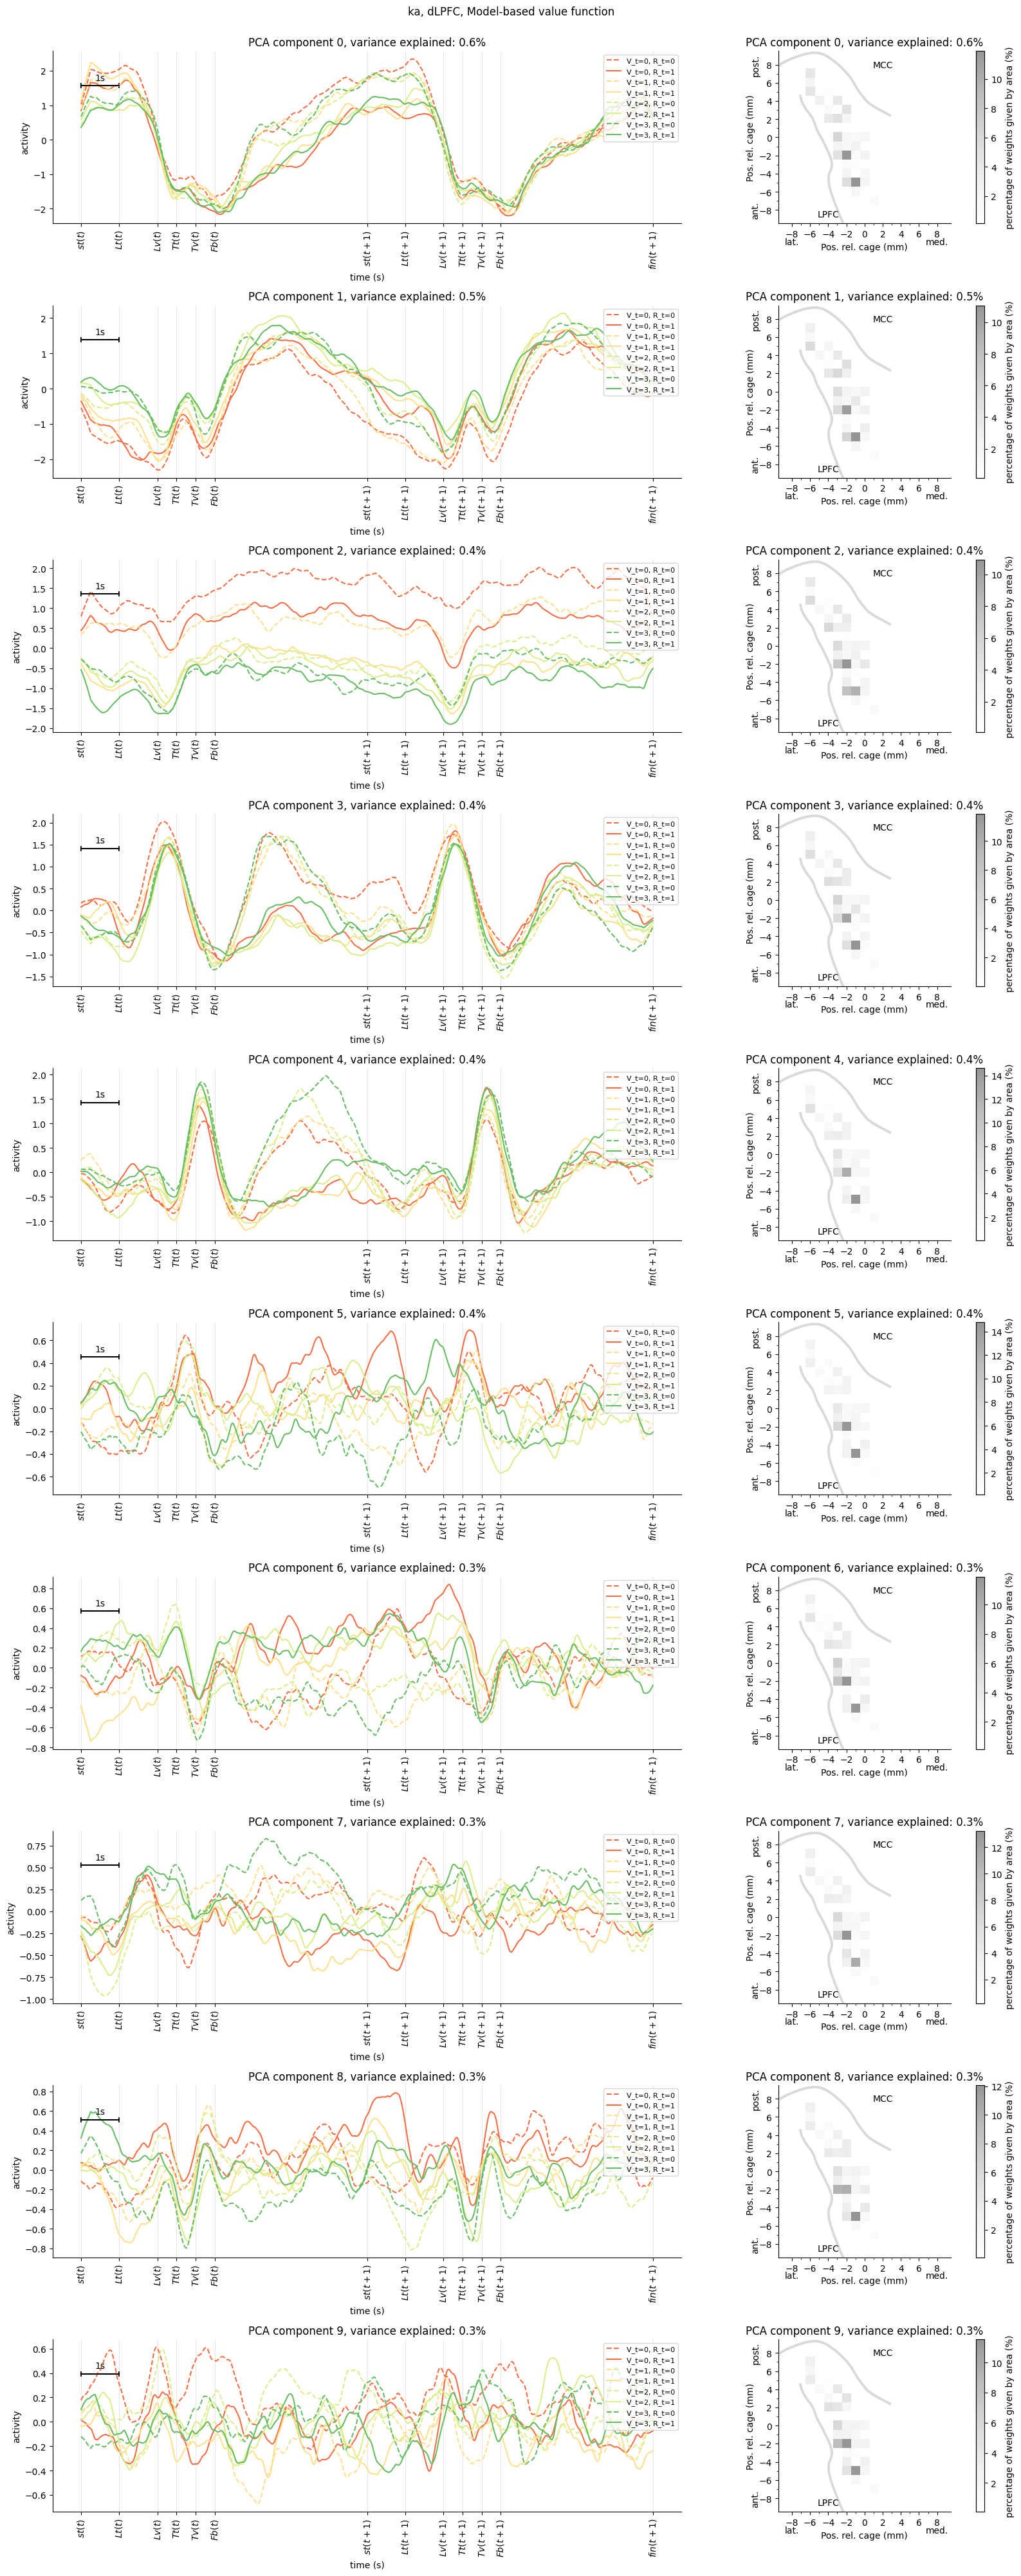

In [8]:
pca_dataset = pca_dataset_dLPFC
pca_components = pca_components_dLPFC
area_title = 'dLPFC, Model-based value function'

plot_pca_components_value(pca_dataset, pca_components, monkey, area_title, n_components=10, t_min=t_min, t_max=t_max)

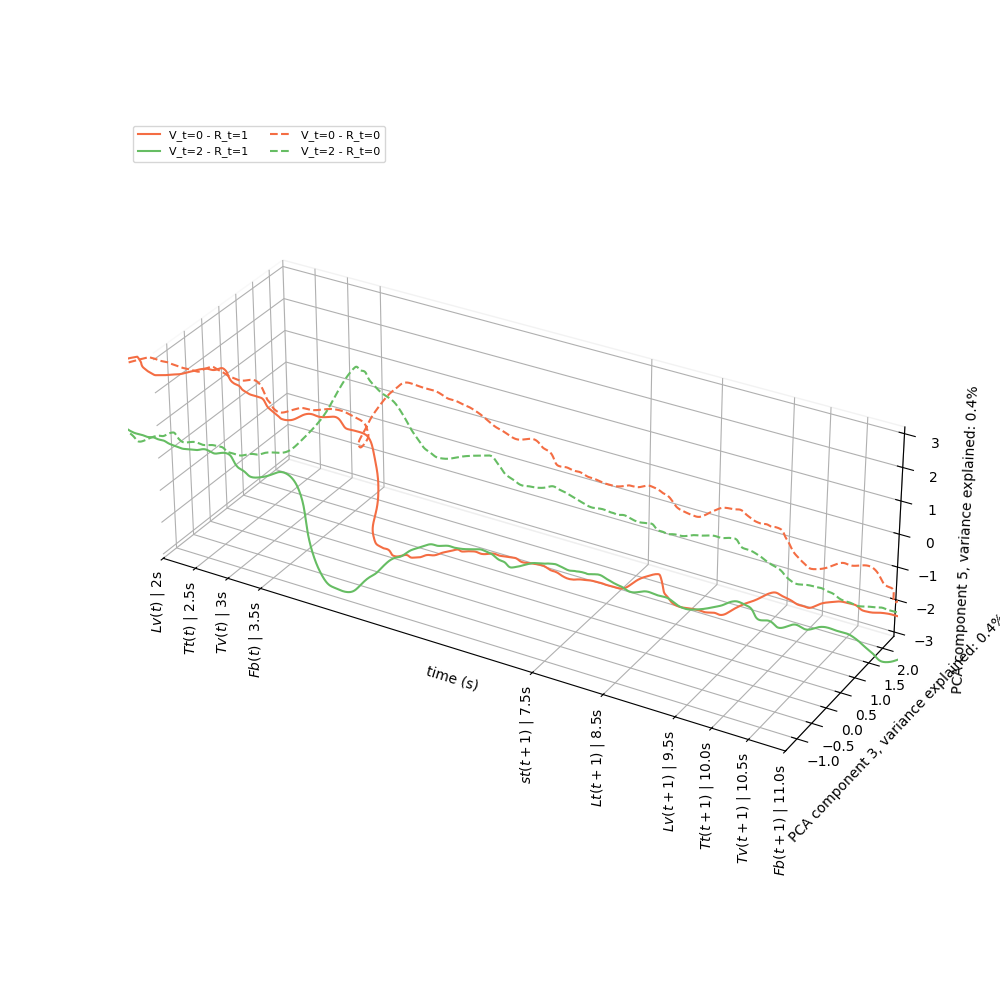

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib widget


monkey = 'ka'
area_title = 'LPFC'

# Get data
unit_data_a = pca_dataset_MCC.firing_rates.sel(pca_component=3)
unit_data_a.data = unit_data_a.data - np.mean(unit_data_a.data, axis=0, keepdims=True)
unit_data_b = pca_dataset_MCC.firing_rates.sel(pca_component=5)
unit_data_b.data = unit_data_b.data - np.mean(unit_data_b.data, axis=0, keepdims=True)

# Create 3D figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
#fig.suptitle(f'PCA components trajectories\n{monkey}, {area}', fontsize=16)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(axis='x')

# make the plot longer along the x axis
ax.set_box_aspect([3, 1, 1])  # aspect ratio is 1:1:1
#ax.set_xticks(np.arange(-3, 4, 1))
#ax.set_yticks(np.arange(-3, 4, 1))


time_vector = pca_dataset.time.values

labels = pca_dataset.value_function.values
labels_2 = pca_dataset.feedback.values
colors = sns.color_palette("RdYlGn", len(np.unique(labels)))
linestyles = {0:'--', 1:'-'}

# Plot the trajectories for each condition
for i, label in enumerate(np.unique(labels)):
    if label in [1, 3]:
        continue
    if label == 2: i+=1
    # Get trials for this condition
    if labels_2 is not None:
        for j, label_2 in enumerate(np.unique(labels_2)):
                trial_ids = unit_data_a.trial_id[(labels == label) & (labels_2 == label_2)]
                mean_count_a = np.mean(unit_data_a.sel(trial_id=trial_ids), axis=0)
                mean_count_b = np.mean(unit_data_b.sel(trial_id=trial_ids), axis=0)

                # smooth in time
                mean_count_a_smooth_data = np.convolve(mean_count_a.values, np.ones(50)/50, mode='same')
                mean_count_b_smooth_data = np.convolve(mean_count_b.values, np.ones(50)/50, mode='same')

                # Plot the trajectory
                ax.plot(time_vector, mean_count_a_smooth_data, mean_count_b_smooth_data, label=f'V_t={label} - R_t={label_2}', color=colors[i], linestyle=linestyles[j])
    else:
        trial_ids = unit_data_a.trial_id[labels == label]
        mean_count_a = np.mean(unit_data_a.sel(trial_id=trial_ids), axis=0)
        mean_count_b = np.mean(unit_data_b.sel(trial_id=trial_ids), axis=0)

        # Plot the trajectory
        ax.plot(time_vector, mean_count_a.values, mean_count_b.values, label=f'V_t={label}', color=colors[i])
    
    # Add markers to show direction of time
    '''ax.scatter(time_vector, mean_a.values, mean_b.values, 
               color=colors[i], s=30, alpha=0.8)'''

# Set labels
ax.set_ylabel(f'PCA component {unit_data_a.pca_component.data}, variance explained: {unit_data_a.explained_var*100:.1f}%')
ax.set_zlabel(f'PCA component {unit_data_b.pca_component.data}, variance explained: {unit_data_b.explained_var*100:.1f}%')
ax.set_xlabel('Time (s)')

# Add legend
# reorder legend labels: put every second on the second column
handles, labels = ax.get_legend_handles_labels()
handles_pos = [handles[i] for i in range(len(labels)) if i % 2 == 1]
handles_neg = [handles[i] for i in range(len(labels)) if i % 2 == 0]
handles = handles_pos + handles_neg
labels_pos = [labels[i] for i in range(len(labels)) if i % 2 == 1]
labels_neg = [labels[i] for i in range(len(labels)) if i % 2 == 0]
labels = labels_pos + labels_neg
ax.legend(handles, labels, loc='upper left', fontsize=8, ncol=2)
#ax.legend(title='history of feedback', loc='upper right')

plot_keypoints(ax, n_extra_trials=(0, 1))

ax.set_xlim(2, 11)

# Export 3d plot in interactive mode
# save to html

#plt.tight_layout()

plt.show()



In [ ]:
mean_count_a

ValueError: cannot add coordinates with new dimensions to a DataArray

In [101]:
# For a simpler approach, use multiple lines with increasing thickness
def plot_lines(mean_count_a, mean_count_b, mean_count_c, t_min, t_max, label, label_2, ax):
    x = mean_count_a.sel(time=slice(t_min, t_max)).data
    y = mean_count_b.sel(time=slice(t_min, t_max)).data
    z = mean_count_c.sel(time=slice(t_min, t_max)).data

    # Number of segments to divide the line into
    num_segments = 10
    segment_size = len(x) // num_segments

    # Plot multiple lines with increasing thickness
    for i_segment in range(num_segments):
        start_idx = i_segment * segment_size
        end_idx = (i_segment + 1) * segment_size if i_segment < num_segments - 1 else len(x)
        
        # Calculate thickness based on segment number
        thickness = 0.5 + (i_segment * 0.5)  # Increases by 0.5 for each segment
        
        # Only add label to the first segment
        if i_segment == 0:
            ax.plot(x[start_idx:end_idx], y[start_idx:end_idx], z[start_idx:end_idx], 
                    color=colors[i], linestyle=linestyles[j], 
                    linewidth=thickness, 
                    label=f'V_t={label} - R_t={label_2}')
        else:
            ax.plot(x[start_idx:end_idx], y[start_idx:end_idx], z[start_idx:end_idx], 
                    color=colors[i], linestyle=linestyles[j], 
                    linewidth=thickness)

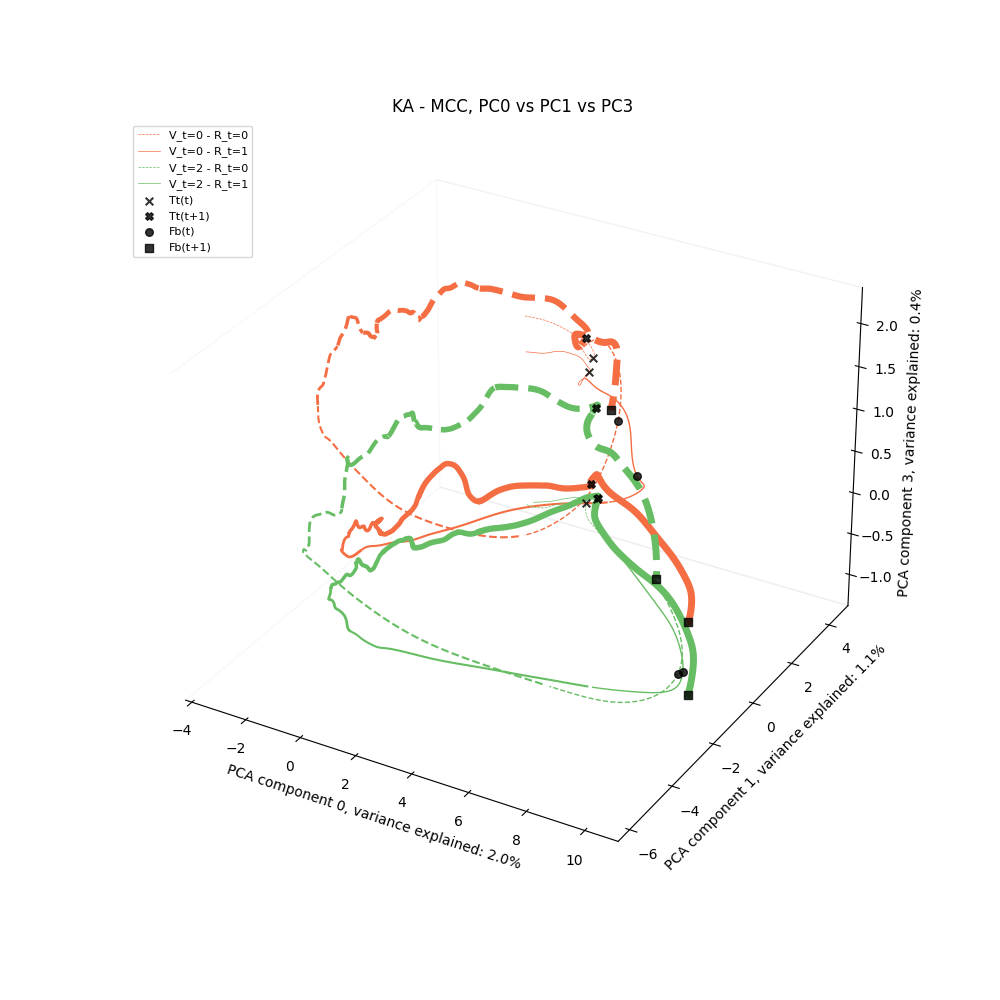

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib widget


monkey = 'ka'
area_title = 'LPFC'

t_min, t_max = 2, 11#0, 11

# Get data
unit_data_a = pca_dataset_MCC.firing_rates.sel(pca_component=0)
#unit_data_a.data = unit_data_a.data - np.mean(unit_data_a.data, axis=0, keepdims=True)
unit_data_b = pca_dataset_MCC.firing_rates.sel(pca_component=1)
#unit_data_b.data = unit_data_b.data - np.mean(unit_data_b.data, axis=0, keepdims=True)
unit_data_c = pca_dataset_MCC.firing_rates.sel(pca_component=3)
unit_data_c.data = unit_data_c.data - np.mean(unit_data_c.data, axis=0, keepdims=True)

# Create 3D figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
#fig.suptitle(f'PCA components trajectories\n{monkey}, {area}', fontsize=16)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
#ax.grid(axis='x')

# make the plot longer along the x axis
#ax.set_box_aspect([3, 1, 1])  # aspect ratio is 1:1:1
#ax.set_xticks(np.arange(-3, 4, 1))
#ax.set_yticks(np.arange(-3, 4, 1))


time_vector = pca_dataset.time.values

labels = pca_dataset.value_function.values
labels_2 = pca_dataset.feedback.values
colors = sns.color_palette("RdYlGn", len(np.unique(labels)))
linestyles = {0:'--', 1:'-'}


# Plot the trajectories for each condition
for i, label in enumerate(np.unique(labels)):
    if label in [1, 3]:
        continue
    if label == 2: i+=1
    # Get trials for this condition
    if labels_2 is not None:
        for j, label_2 in enumerate(np.unique(labels_2)):
                trial_ids = unit_data_a.trial_id[(labels == label) & (labels_2 == label_2)]
                mean_count_a = unit_data_a.sel(trial_id=trial_ids).mean(dim='trial_id')
                mean_count_b = unit_data_b.sel(trial_id=trial_ids).mean(dim='trial_id')
                mean_count_c = unit_data_c.sel(trial_id=trial_ids).mean(dim='trial_id')

                # smooth in time
                mean_count_a.data = np.convolve(mean_count_a.values, np.ones(50)/50, mode='same')
                mean_count_b.data = np.convolve(mean_count_b.values, np.ones(50)/50, mode='same')
                mean_count_c.data = np.convolve(mean_count_c.values, np.ones(50)/50, mode='same')

                # Plot the trajectory
                plot_lines(mean_count_a, mean_count_b, mean_count_c, t_min, t_max, label, label_2, ax)

                # scatter times: LV_t: t=2, Fb_t: t=3.5, LV_t+1: t=9.5, Fb_t+1: t=11
                ax.scatter(mean_count_a.sel(time=2.5).data, mean_count_b.sel(time=2.5).data, mean_count_c.sel(time=2.5).data, color='k', s=30, alpha=0.8, marker='x')
                ax.scatter(mean_count_a.sel(time=3.5).data, mean_count_b.sel(time=3.5).data, mean_count_c.sel(time=3.5).data, color='k', s=30, alpha=0.8, marker='o')
                ax.scatter(mean_count_a.sel(time=10).data, mean_count_b.sel(time=10).data, mean_count_c.sel(time=10).data, color='k', s=30, alpha=0.8, marker='X')
                #ax.scatter(mean_count_a.sel(time=9.5).data, mean_count_b.sel(time=9.5).data, mean_count_c.sel(time=9.5).data, label='Lv(t+1)', color='k', s=30, alpha=0.8, marker='^')
                ax.scatter(mean_count_a.sel(time=11).data, mean_count_b.sel(time=11).data, mean_count_c.sel(time=11).data, color='k', s=30, alpha=0.8, marker='s')
    else:
        trial_ids = unit_data_a.trial_id[labels == label]
        mean_count_a = np.mean(unit_data_a.sel(trial_id=trial_ids), axis=0)
        mean_count_b = np.mean(unit_data_b.sel(trial_id=trial_ids), axis=0)
        mean_count_c = np.mean(unit_data_c.sel(trial_id=trial_ids), axis=0)

        # Plot the trajectory
        ax.plot(mean_count_a.values, mean_count_b.values, mean_count_c.values, label=f'V_t={label}', color=colors[i])
    
    # Add markers to show direction of time
    '''ax.scatter(time_vector, mean_a.values, mean_b.values, 
               color=colors[i], s=30, alpha=0.8)'''




# Set labels
ax.set_xlabel(f'PCA component {unit_data_a.pca_component.data}, variance explained: {unit_data_a.explained_var*100:.1f}%')
ax.set_ylabel(f'PCA component {unit_data_b.pca_component.data}, variance explained: {unit_data_b.explained_var*100:.1f}%')
ax.set_zlabel(f'PCA component {unit_data_c.pca_component.data}, variance explained: {unit_data_c.explained_var*100:.1f}%')


# reorder legend labels: put every second on the second column
handles, labels = ax.get_legend_handles_labels()
handles_pos = [handles[i] for i in range(len(labels)) if i % 2 == 1]
handles_neg = [handles[i] for i in range(len(labels)) if i % 2 == 0]
handles = handles_pos + handles_neg
labels_pos = [labels[i] for i in range(len(labels)) if i % 2 == 1]
labels_neg = [labels[i] for i in range(len(labels)) if i % 2 == 0]
labels = labels_pos + labels_neg

# Add legend
ax.scatter([], [], [], color='k', s=30, alpha=0.8, marker='x', label='Tt(t)')
ax.scatter([], [], [], color='k', s=30, alpha=0.8, marker='X', label='Tt(t+1)')
ax.scatter([], [], [], color='k', s=30, alpha=0.8, marker='o', label='Fb(t)')
ax.scatter([], [], [], color='k', s=30, alpha=0.8, marker='s', label='Fb(t+1)')

# Reorder legend labels: add scattered markers last
handles, labels = ax.get_legend_handles_labels()
scattered_handles = handles[-3:]  # Last three are the scattered markers
scattered_labels = labels[-3:]
other_handles = handles[:-3]
other_labels = labels[:-3]

handles = other_handles + scattered_handles
labels = other_labels + scattered_labels

ax.legend(handles, labels, loc='upper left', fontsize=8, ncol=1)

ax.legend(handles, labels, loc='upper left', fontsize=8, ncol=1)
#ax.legend(title='history of feedback', loc='upper right')

#plot_keypoints(ax, n_extra_trials=(0, 1))

#ax.set_xlim(2, 11)
ax.grid(None)
# Export 3d plot in interactive mode
# save to html

plt.title(f'KA - MCC, PC{unit_data_a.pca_component.data} vs PC{unit_data_b.pca_component.data} vs PC{unit_data_c.pca_component.data}')

plt.show()

